In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_ddelay(div_ratio, n):
    rv = []
    lo = math.floor(div_ratio)
    hi = lo + 1
    if 0.5 <= div_ratio - lo and 0 < n:
        rv.append(hi)
        hi += 1
        n -= 1
    while 0 < n:
        rv.append(lo)
        lo -= 1
        n -= 1
        if n <= 0:
            break
        rv.append(hi)
        hi += 1
        n -= 1
    return rv

In [3]:
n_harm = 1
div_ratio = 48000/440
ddelay = np.array(make_ddelay(div_ratio, 4)[::-1])
phase_delay = -2*np.pi*ddelay[None, :]/div_ratio*np.arange(1, n_harm+1)[:, None]

In [4]:
div_ratio, ddelay, phase_delay

(109.0909090909091,
 array([111, 108, 110, 109]),
 array([[-6.39314105, -6.22035345, -6.33554518, -6.27794932]]))

In [5]:
sys = np.hstack(
    (np.vstack((np.cos(phase_delay[0:1]), np.sin(phase_delay))),
     np.vstack((np.ones((1, 1)), np.zeros((n_harm, 1))))))

In [6]:
sys

array([[ 0.99396096,  0.99802673,  0.99862953,  0.99998629,  1.        ],
       [-0.10973431,  0.06279052, -0.05233596,  0.00523596,  0.        ]])

In [7]:
constraint = np.linalg.solve(sys[:,0:sys.shape[0]], sys[:,sys.shape[0]:])

In [8]:
constraint

array([[0.66851481, 0.33481259, 0.3652117 ],
       [0.33481259, 0.66851481, 0.63825327]])

In [9]:
b = np.sinc(div_ratio - ddelay)

In [10]:
b

array([-0.04697433, -0.08220507,  0.09864608,  0.98646084])

In [11]:
b[:constraint.shape[0]] -= constraint[:,-1]

In [12]:
b

array([-0.41218603, -0.72045834,  0.09864608,  0.98646084])

In [13]:
a = np.vstack((-constraint[:,:-1], np.eye(constraint.shape[1]-1)))

In [14]:
a

array([[-0.66851481, -0.33481259],
       [-0.33481259, -0.66851481],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ]])

In [15]:
dof = np.linalg.lstsq(a, b, rcond=-1)

In [16]:
dof

(array([0.10782516, 0.99924507]),
 array([0.00054565]),
 2,
 array([1.41656834, 1.05420927]))

In [17]:
coeff = np.hstack(
    (np.dot(constraint, np.hstack((-dof[0], [1]))),
     dof[0]))

In [18]:
coeff

array([-0.04143084, -0.06585808,  0.10782516,  0.99924507])

In [19]:
f_norm_test = np.arange(0, 0.5, 0.001)

In [20]:
transf = (np.exp(-2j*np.pi*ddelay[None, :]*f_norm_test[:, None])*coeff[None, :]).sum(axis=1)

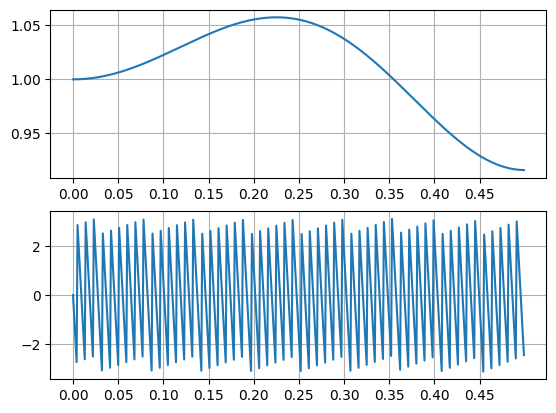

In [21]:
fig, ax = plt.subplots(2)
ax[0].plot(f_norm_test, np.abs(transf))
ax[1].plot(f_norm_test, np.angle(transf))
ax[0].set_xticks(f_norm_test[0::50])
ax[0].grid()
ax[1].set_xticks(f_norm_test[0::50])
ax[1].grid()